In [14]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/drive/MyDrive/ANN_Project_data/original_image_dataset.zip'
extract_dir = '/content/original_image_dataset/'

# Create extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted files to {extract_dir}")

# List the contents of the extracted folder
for root, dirs, files in os.walk(extract_dir):
    print(f"\nDirectory: {root}")
    for file in files:
        print(file)


Extracted files to /content/original_image_dataset/

Directory: /content/original_image_dataset/

Directory: /content/original_image_dataset/downloaded_images_manual

Directory: /content/original_image_dataset/downloaded_images_manual/label_1
image_4506.jpg
image_6122.jpg
image_4378.jpg
image_5880.jpg
image_3232.jpg
image_5164.jpg
image_6008.jpg
image_3115.jpg
image_5986.jpg
image_3087.jpg
image_4193.jpg
image_4081.jpg
image_6100.jpg
image_4973.jpg
image_5830.jpg
image_3795.jpg
image_5776.jpg
image_4179.jpg
image_4864.jpg
image_4672.jpg
image_3441.jpg
image_4666.jpg
image_4474.jpg
image_5175.jpg
image_4919.jpg
image_3955.jpg
image_4553.jpg
image_5135.jpg
image_5434.jpg
image_3329.jpg
image_3705.jpg
image_3738.jpg
image_4552.jpg
image_3651.jpg
image_5021.jpg
image_3450.jpg
image_5262.jpg
image_3168.jpg
image_3623.jpg
image_5345.jpg
image_5398.jpg
image_5229.jpg
image_3578.jpg
image_4870.jpg
image_3363.jpg
image_4714.jpg
image_5048.jpg
image_5866.jpg
image_5213.jpg
image_6011.jpg
image_5

In [15]:
import pandas as pd
import os

# Load the filtered CSV
csv_path = '/content/drive/MyDrive/ANN_Project_data/filtered_dataset_clean.csv'
df = pd.read_csv(csv_path)

# Base image folder
base_dir = '/content/original_image_dataset/downloaded_images_manual'

# Add a new column for the full image path based on label and ID
def get_image_path(row):
    label_folder = f"label_{row['label']}"
    # Make sure image filenames match CSV ID naming convention, e.g., 'image_123.jpg'
    filename = f"image_{row['ID']}.jpg"
    return os.path.join(base_dir, label_folder, filename)

df['image_path'] = df.apply(get_image_path, axis=1)

# Check some entries
print(df[['ID', 'label', 'image_path']].head())


   ID  label                                         image_path
0   1      0  /content/original_image_dataset/downloaded_ima...
1   2      0  /content/original_image_dataset/downloaded_ima...
2   3      0  /content/original_image_dataset/downloaded_ima...
3   4      0  /content/original_image_dataset/downloaded_ima...
4   5      0  /content/original_image_dataset/downloaded_ima...


In [16]:
%pip install transformers datasets

In [17]:
# Load ViT-GPT2 model and processors
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image
import pandas as pd
from tqdm import tqdm

model_name = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(model_name)
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (inte

In [18]:
from PIL import Image

def preprocess_and_filter_images(df, min_size=50):
    valid_paths = []
    invalid_indices = []

    for idx, row in df.iterrows():
        img_path = row['image_path']
        try:
            img = Image.open(img_path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            if img.width < min_size or img.height < min_size:
                print(f"Skipping small image at {img_path} with size {img.size}")
                invalid_indices.append(idx)
                continue
            valid_paths.append(img_path)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            invalid_indices.append(idx)

    # Remove invalid rows from df
    df_clean = df.drop(invalid_indices).reset_index(drop=True)
    return df_clean

# Run preprocessing filter
df_clean = preprocess_and_filter_images(df)
print(f"Images before: {len(df)}, after cleaning: {len(df_clean)}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_10.jpg with size (32, 32)
Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_12.jpg with size (16, 16)
Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_69.jpg with size (16, 16)
Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_97.jpg with size (32, 32)
Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_133.jpg with size (16, 16)
Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_199.jpg with size (32, 32)
Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_224.jpg with size (48, 48)
Skipping small image at /content/original_image_dataset/downloaded_images_manual/label_0/image_252.jpg with size (32, 32)
Skipping small image at /con

In [19]:
# Save the cleaned dataframe to a CSV file
output_path = '/content/filtered_dataset_clean_preprocessed.csv'
df_clean.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to {output_path}")


Cleaned dataset saved to /content/filtered_dataset_clean_preprocessed.csv


In [20]:
def generate_caption(image_path, max_length=16, num_beams=4):
    try:
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Skip very small images just in case
        if image.width < 50 or image.height < 50:
            print(f"Skipping small image during generation: {image_path} size: {image.size}")
            return ""

        pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values.to(device)

        output_ids = model.generate(
            pixel_values,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True
        )

        caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return caption

    except Exception as e:
        print(f"Error generating caption for {image_path}: {e}")
        return ""


In [22]:
captions = []
for img_path in tqdm(df_clean['image_path'], desc="Generating captions"):
    captions.append(generate_caption(img_path))

df_clean['generated_caption'] = captions


Generating captions: 100%|██████████| 5386/5386 [23:09<00:00,  3.88it/s]


In [23]:
output_csv = '/content/filtered_dataset_with_captions.csv'
df.to_csv(output_csv, index=False)
print(f"Saved dataframe with generated captions to {output_csv}")


Saved dataframe with generated captions to /content/filtered_dataset_with_captions.csv


In [30]:
df_clean['combined_text'] = df_clean['text'].fillna('') + ' ' + df_clean['generated_caption'].fillna('')

In [31]:
texts = df_clean['combined_text'].tolist()
labels = df_clean['label'].tolist()

In [33]:
%pip install transformers

In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np


In [36]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [37]:
# Prepare splits
texts = df_clean['combined_text'].tolist()
labels = df_clean['label'].tolist()

X_trainval, X_test, y_trainval, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = FakeNewsDataset(X_train, y_train, tokenizer)
val_dataset = FakeNewsDataset(X_val, y_val, tokenizer)
test_dataset = FakeNewsDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
def train_epoch(model, data_loader, optimizer, device, criterion):
    model.train()
    losses = []
    correct_preds = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        correct_preds += torch.sum(preds == labels)

    return correct_preds.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device, criterion):
    model.eval()
    losses = []
    correct_preds = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = criterion(logits, labels)

            losses.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            correct_preds += torch.sum(preds == labels)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    return acc, np.mean(losses), precision, recall, f1


In [41]:
class EarlyStopping:
    def __init__(self, patience=3):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return

        # Strict improvement check: val_loss must be strictly less than best_loss
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0  # reset counter on improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [42]:
num_epochs = 20
early_stopping = EarlyStopping(patience=3)

for epoch in range(num_epochs):
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, criterion)
    val_acc, val_loss, val_prec, val_rec, val_f1 = eval_model(model, val_loader, device, criterion)

    print(f"Epoch {epoch + 1}/{num_epochs}", flush=True)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}", flush=True)
    print(f"Validation loss: {val_loss:.4f} | Validation accuracy: {val_acc:.4f}", flush=True)
    print(f"Validation Precision: {val_prec:.4f} | Recall: {val_rec:.4f} | F1: {val_f1:.4f}", flush=True)
    print("-" * 40, flush=True)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.", flush=True)
        break

Epoch 1/20
Train loss: 0.5290 | Train accuracy: 0.7325
Validation loss: 0.4903 | Validation accuracy: 0.7541
Validation Precision: 0.7551 | Recall: 0.7541 | F1: 0.7540
----------------------------------------
Epoch 2/20
Train loss: 0.3890 | Train accuracy: 0.8277
Validation loss: 0.5121 | Validation accuracy: 0.7564
Validation Precision: 0.7564 | Recall: 0.7564 | F1: 0.7564
----------------------------------------
Epoch 3/20
Train loss: 0.2592 | Train accuracy: 0.8984
Validation loss: 0.5799 | Validation accuracy: 0.7494
Validation Precision: 0.7511 | Recall: 0.7494 | F1: 0.7492
----------------------------------------
Epoch 4/20
Train loss: 0.1519 | Train accuracy: 0.9461
Validation loss: 0.6667 | Validation accuracy: 0.7262
Validation Precision: 0.7291 | Recall: 0.7262 | F1: 0.7257
----------------------------------------
Early stopping triggered. Stopping training.


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [45]:
print(classification_report(all_labels, all_preds, digits=4))


              precision    recall  f1-score   support

           0     0.7504    0.7971    0.7730       547
           1     0.7767    0.7269    0.7510       531

    accuracy                         0.7625      1078
   macro avg     0.7635    0.7620    0.7620      1078
weighted avg     0.7634    0.7625    0.7622      1078



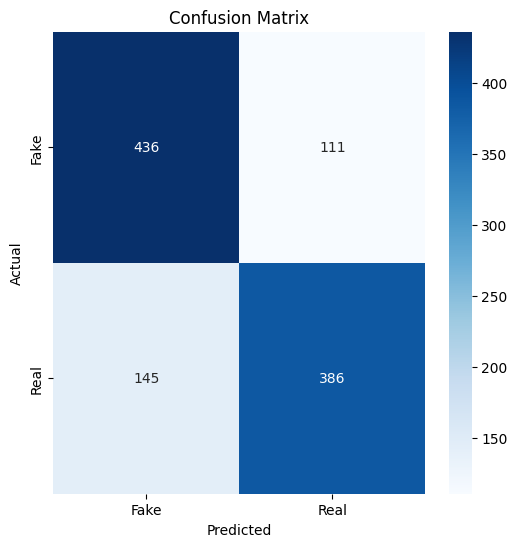

In [46]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
